# Script for testing methods to detect sound responsive areas in xcranial qcam data

In [60]:
# path for single animal
dPath = "./data/AA0310"

# explore single acquisition

In [61]:
import os
from lib.qcam import extract_qcamraw

file = "AA0310AAAA0007.qcamraw"
frameRate = 20

# example for one qcam file
filepath = os.path.join(dPath,file)
img,t,header = extract_qcamraw(filepath,frameRate)

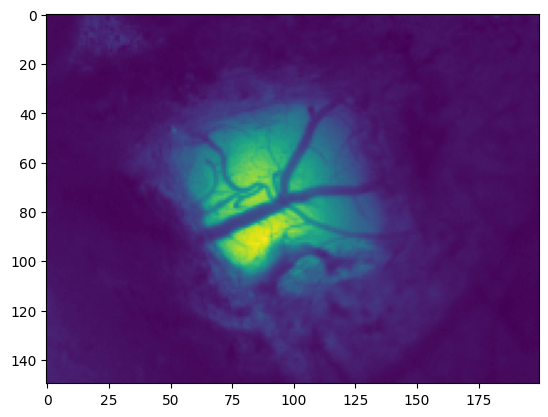

In [62]:
import matplotlib.pyplot as plt
plt.imshow(img[:,:,0])

In [4]:
# FR not adjustable
# import plotly.express as px
# fig = px.imshow(
#     img, 
#     animation_frame=2,
# )
# fig.show()

In [5]:
# # video in notebook
# %matplotlib inline
# from matplotlib import pyplot as plt
# from matplotlib import animation
# from IPython.display import HTML

# # frame rate
# fr = 20
# interval = int(1/fr*1000) #ms

# # Create a figure and axes
# fig, ax = plt.subplots()

# # Initialize an image object
# im = ax.imshow(img[:,:,0])
# plt.close()

# # def init():
# #     im.set_data(img[:,:,0])
# # Define the update function for the animation
# def update(frame):
#     im.set_data(img[:,:,frame])
#     return im,

# # Create the animation object
# ani = animation.FuncAnimation(fig, update, frames=range(img.shape[2]), interval=interval, blit=True)

# # Show the animation
# # plt.show()
# HTML(ani.to_html5_video())

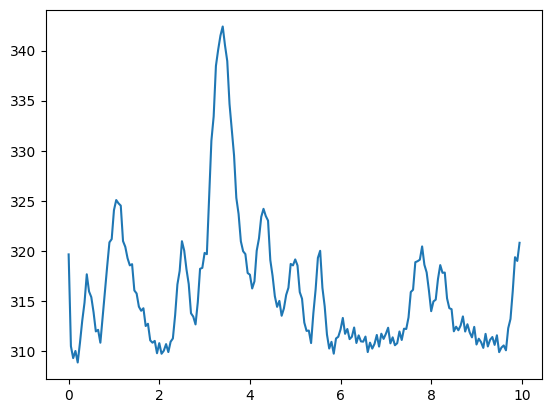

In [29]:
import numpy as np
signal = np.reshape(img,(np.prod(img.shape[:2]),img.shape[2])).mean(axis=0)
plt.plot(t,signal)

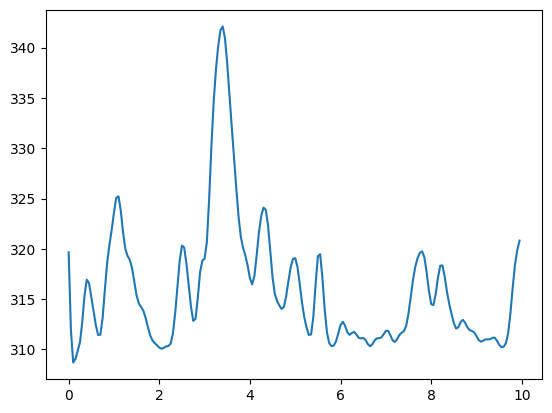

In [30]:
from lib.signals import butterFilter
plt.plot(t,butterFilter(signal))

Text(0.5, 1.0, './data/AA0310/AA0310AAAA0007.qcamraw')

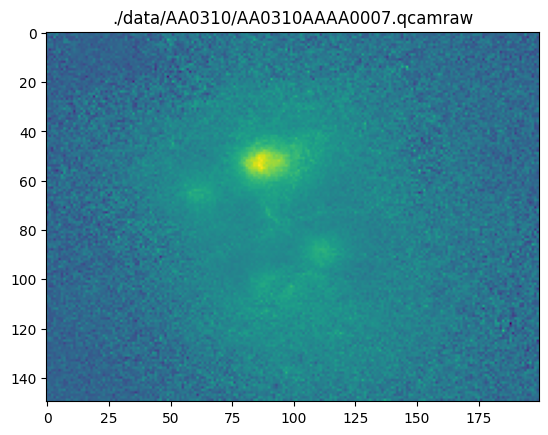

In [31]:
from lib.qcam import calcSpatialDFFresp
# def calcSpatialDFFresp(img, t: np.ndarray, frameRate: int = 20,
#                baseline: tuple[int] = (2,3),
#                stimlen: float = 0.4,
#                temporalAvgFrameSpan: int = 10,
#                applyButterFilter: bool = True)
plt.imshow(calcSpatialDFFresp(img, t))
plt.title(filepath)

# look at spatial dFF for each animal

In [33]:
import glob

allDir = os.path.dirname(dPath)
paths = glob.glob(os.path.join(allDir,'*AA*'))

for animal in paths:
    Qfs = glob.glob(os.path.join(animal,'*.qcamraw'))
    for q in Qfs:
        try:
            img,t,_ = extract_qcamraw(q,20)
            plt.imshow(calcSpatialDFFresp(img, t))
            plt.title(q)
            plt.show()
        except:
            print(f"issue with {q}")


# average multiple traces together

([<matplotlib.axis.XTick at 0x721ec8f7a7e0>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9')])

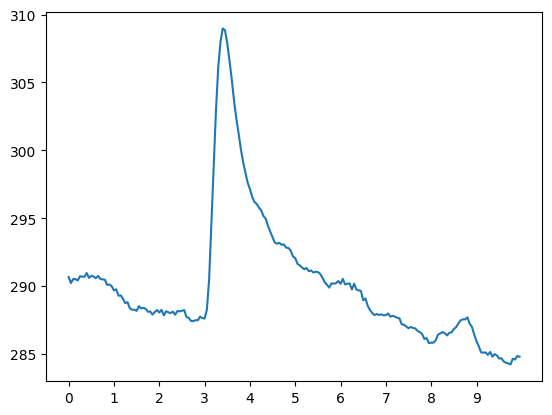

In [35]:
import glob
Qfs = glob.glob(os.path.join(dPath,'*.qcamraw'))
# Qfs2 = glob.glob(os.path.join(os.path.dirname(dPath),'AA0308/*.qcamraw'))
# Qfs3 = glob.glob(os.path.join(os.path.dirname(dPath),'AA0315/*.qcamraw'))
# Qfs = Qfs+Qfs2+Qfs3

fs = 20
imgs = []
for q in Qfs:
    img,_,_ = extract_qcamraw(q,fs)
    imgs.append(img.reshape(-1,200))

plt.plot(t,np.vstack(imgs).mean(axis=0))
plt.xticks(np.arange(0,int(max(t))+1))


# compare 'unbiased' approaches

In [73]:
file = "AA0310AAAA0007.qcamraw"
frameRate = 20

# example for one qcam file
filepath = os.path.join(dPath,file)
img,t,header = extract_qcamraw(filepath,frameRate)

reshaped_data = img.reshape(-1,200)

baseline = (2,3)
sound_stim_start = 3 #s
stimulation_length = 0.4 #s

# Example: Define sound and baseline periods (adjust indices as needed)
sound_response_search_len = 4 #s
sound_period = np.where((t>=sound_stim_start+stimulation_length) & (t<=sound_stim_start+sound_response_search_len))[0]  # Adjust indices to match your sound window
baseline_period = np.where((t>=baseline[0]) & (t<baseline[-1]))[0]  # Adjust indices to match your baseline window



## k-means

In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# kmeans_input = reshaped_data
kmeans_input = butterFilter(reshaped_data)

# Normalize data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(kmeans_input)

# Define number of clusters (adjust as needed)
n_clusters = 6

# Apply k-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(normalized_data)

# Reshape labels to original image dimensions
cluster_map = cluster_labels.reshape(150, 200)

In [75]:
#Compute mean fluorescence for each cluster during sound and baseline

cluster_responses = []
for cluster_id in range(n_clusters):
    cluster_mask = cluster_map == cluster_id
    mean_sound = img[cluster_mask, :][:, sound_period].mean()
    mean_baseline = img[cluster_mask, :][:, baseline_period].mean()
    cluster_responses.append((cluster_id, mean_sound - mean_baseline))

# Sort clusters by response strength
sorted_clusters = sorted(cluster_responses, key=lambda x: x[1], reverse=True)
print(f"Clusters sorted by response strength: {sorted_clusters}")

Clusters sorted by response strength: [(5, np.float64(19.018719993141303)), (2, np.float64(16.817589820359217)), (1, np.float64(9.564738789913008)), (3, np.float64(5.6943064020420024)), (0, np.float64(2.512934253414187)), (4, np.float64(0.3875879961333055))]


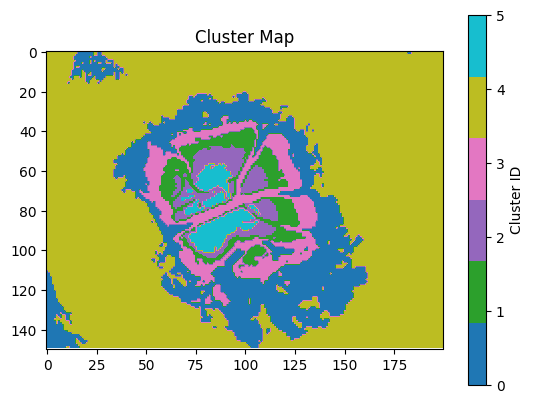

In [76]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

cmap = plt.get_cmap('tab10')
new_cmap = mcolors.ListedColormap(cmap(np.linspace(0, 1, n_clusters))) # 5 colors instead of the default 256

plt.imshow(cluster_map, cmap=new_cmap)
plt.title("Cluster Map")
plt.colorbar(label="Cluster ID")
plt.show()

## gaussian mixture model

In [77]:
from sklearn.mixture import GaussianMixture

gmm_input = butterFilter(reshaped_data)

# Normalize data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(gmm_input)

# Define the number of clusters
n_clusters = 6

# Apply Gaussian Mixture Model
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
gmm_labels = gmm.fit_predict(normalized_data)

# Reshape labels to the original spatial dimensions (150x200)
cluster_map = gmm_labels.reshape(150, 200)

In [78]:
# Compute mean fluorescence for each cluster during sound and baseline

# Calculate response differences for each cluster
cluster_responses = []
for cluster_id in range(n_clusters):
    cluster_mask = cluster_map == cluster_id
    mean_sound = img[cluster_mask, :][:, sound_period].mean()
    mean_baseline = img[cluster_mask, :][:, baseline_period].mean()
    cluster_responses.append((cluster_id, mean_sound - mean_baseline))

# Sort clusters by response strength
sorted_clusters = sorted(cluster_responses, key=lambda x: x[1], reverse=True)
print(f"Clusters sorted by response strength: {sorted_clusters}")

Clusters sorted by response strength: [(5, np.float64(18.53224846894136)), (2, np.float64(17.404551989877973)), (1, np.float64(9.46875)), (3, np.float64(5.309713934713955)), (0, np.float64(1.9031684932727444)), (4, np.float64(0.3217374499394623))]


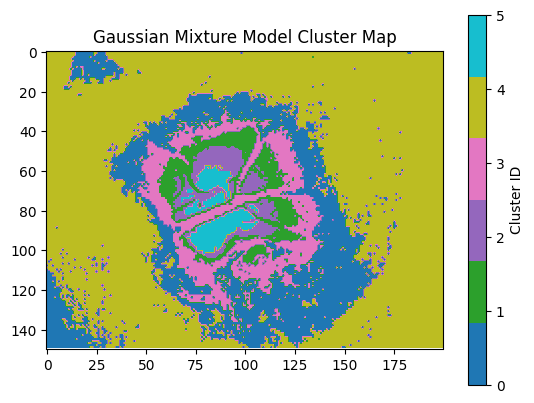

In [79]:
# Plot the cluster map
cmap = plt.get_cmap('tab10')
new_cmap = mcolors.ListedColormap(cmap(np.linspace(0, 1, n_clusters))) # 5 colors instead of the default 256

plt.imshow(cluster_map, cmap=new_cmap)
plt.title("Gaussian Mixture Model Cluster Map")
plt.colorbar(label="Cluster ID")
plt.show()

## PCA

In [80]:
from sklearn.decomposition import PCA

pca_input = butterFilter(reshaped_data)

# Normalize data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(pca_input)

# Extract sound and baseline data
sound_data = normalized_data[:, sound_period]
baseline_data = normalized_data[:, baseline_period]

n_pca_components = 6
# Apply PCA to the sound data
pca_sound = PCA(n_components=n_pca_components)  # Number of components to retain
pcs_sound = pca_sound.fit_transform(sound_data)

# Apply PCA to the baseline data | 5
pca_baseline = PCA(n_components=n_pca_components)
pcs_baseline = pca_baseline.fit_transform(baseline_data)

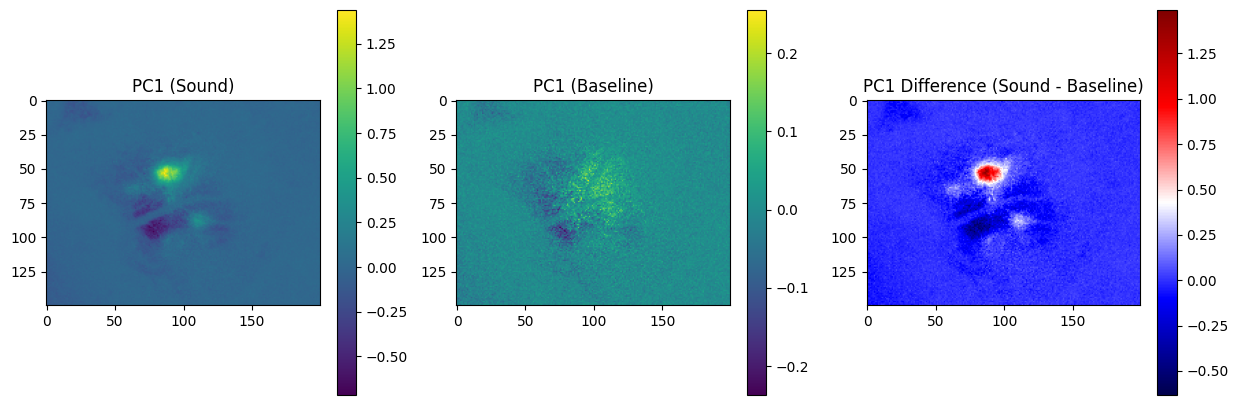

In [81]:
# select principal component (0: first, 1: second, etc)
PC_sel = 1

# Get the principal component for visualization
pc_sound = pcs_sound[:, PC_sel]  #  principal component (sound)
pc_baseline = pcs_baseline[:, PC_sel]  #  principal component (baseline)

# Reshape PC back to spatial dimensions for visualization
pc_sound_map = pc_sound.reshape(*img.shape[:2])
pc_baseline_map = pc_baseline.reshape(*img.shape[:2])

# Calculate the difference between sound and baseline PCs
pc_diff_map = pc_sound_map - pc_baseline_map

#FIGURE
plt.figure(figsize=(15, 5))

# Sound PC2
plt.subplot(1, 3, 1)
plt.imshow(pc_sound_map, cmap="viridis")
plt.title(f"PC{PC_sel} (Sound)")
plt.colorbar()

# Baseline PC1
plt.subplot(1, 3, 2)
plt.imshow(pc_baseline_map, cmap="viridis")
plt.title(f"PC{PC_sel} (Baseline)")
plt.colorbar()

# Difference
plt.subplot(1, 3, 3)
plt.imshow(pc_diff_map, cmap="seismic")
plt.title(f"PC{PC_sel} Difference (Sound - Baseline)")
plt.colorbar()

plt.show()

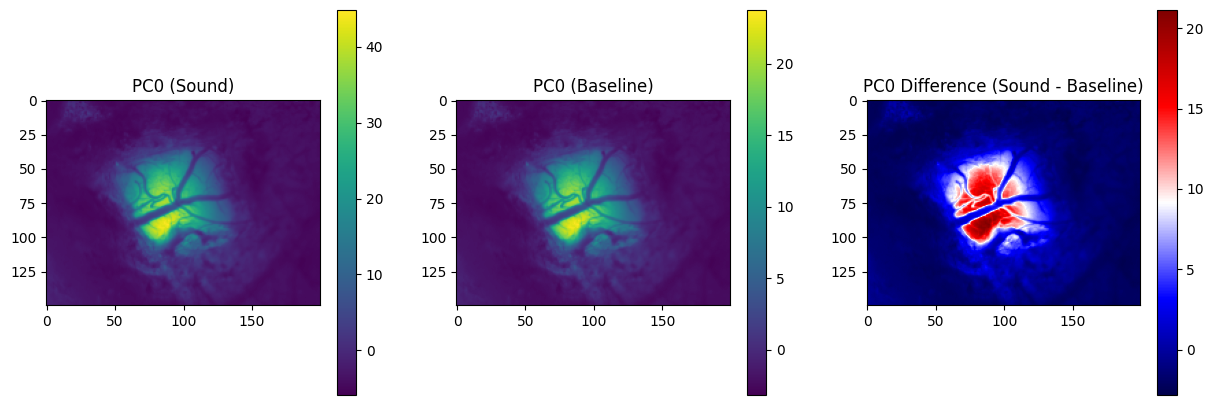

In [82]:
# select principal component (0: first, 1: second, etc)
PC_sel = 0

# Get the principal component for visualization
pc_sound = pcs_sound[:, PC_sel]  #  principal component (sound)
pc_baseline = pcs_baseline[:, PC_sel]  #  principal component (baseline)

# Reshape PC back to spatial dimensions for visualization
pc_sound_map = pc_sound.reshape(*img.shape[:2])
pc_baseline_map = pc_baseline.reshape(*img.shape[:2])

# Calculate the difference between sound and baseline PCs
pc_diff_map = pc_sound_map - pc_baseline_map

#FIGURE
plt.figure(figsize=(15, 5))

# Sound PC2
plt.subplot(1, 3, 1)
plt.imshow(pc_sound_map, cmap="viridis")
plt.title(f"PC{PC_sel} (Sound)")
plt.colorbar()

# Baseline PC1
plt.subplot(1, 3, 2)
plt.imshow(pc_baseline_map, cmap="viridis")
plt.title(f"PC{PC_sel} (Baseline)")
plt.colorbar()

# Difference
plt.subplot(1, 3, 3)
plt.imshow(pc_diff_map, cmap="seismic")
plt.title(f"PC{PC_sel} Difference (Sound - Baseline)")
plt.colorbar()

plt.show()

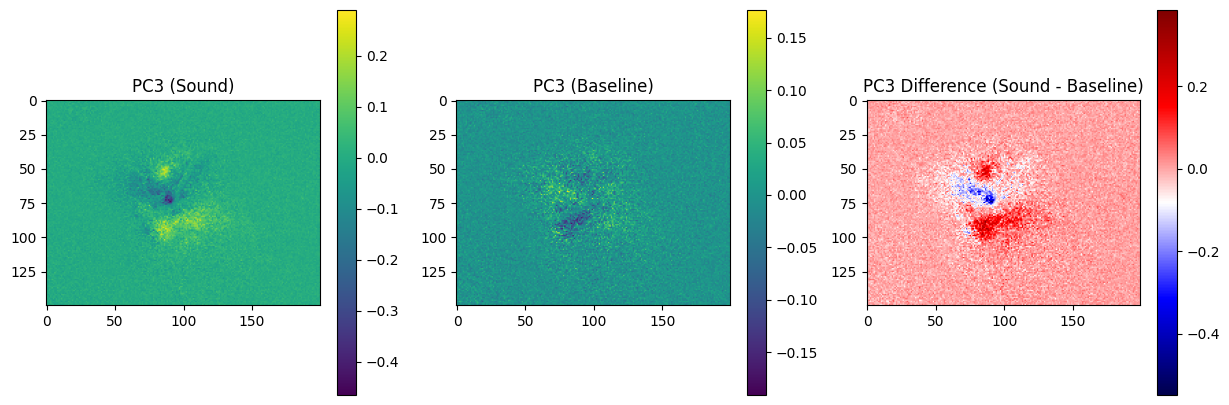

In [83]:
# select principal component (0: first, 1: second, etc)
PC_sel = 3

# Get the principal component for visualization
pc_sound = pcs_sound[:, PC_sel]  #  principal component (sound)
pc_baseline = pcs_baseline[:, PC_sel]  #  principal component (baseline)

# Reshape PC back to spatial dimensions for visualization
pc_sound_map = pc_sound.reshape(*img.shape[:2])
pc_baseline_map = pc_baseline.reshape(*img.shape[:2])

# Calculate the difference between sound and baseline PCs
pc_diff_map = pc_sound_map - pc_baseline_map

#FIGURE
plt.figure(figsize=(15, 5))

# Sound PC2
plt.subplot(1, 3, 1)
plt.imshow(pc_sound_map, cmap="viridis")
plt.title(f"PC{PC_sel} (Sound)")
plt.colorbar()

# Baseline PC1
plt.subplot(1, 3, 2)
plt.imshow(pc_baseline_map, cmap="viridis")
plt.title(f"PC{PC_sel} (Baseline)")
plt.colorbar()

# Difference
plt.subplot(1, 3, 3)
plt.imshow(pc_diff_map, cmap="seismic")
plt.title(f"PC{PC_sel} Difference (Sound - Baseline)")
plt.colorbar()

plt.show()

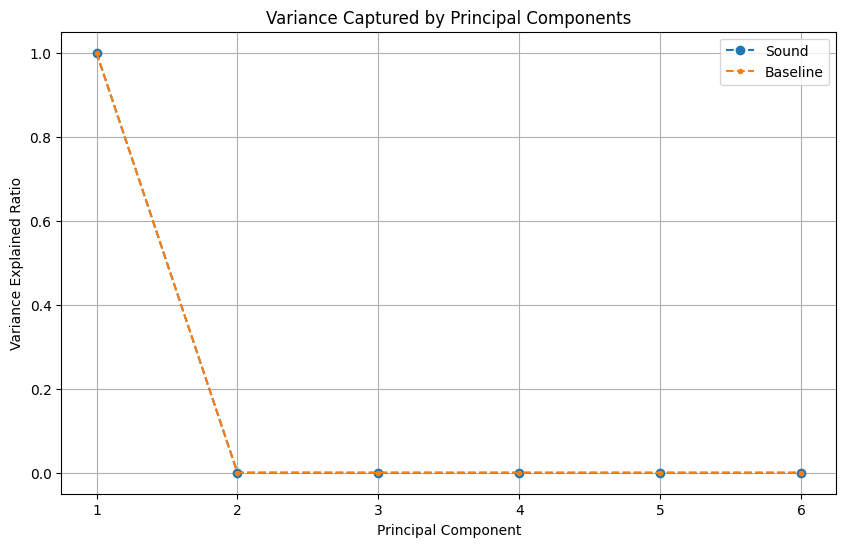

In [84]:
# Variance explained by each component for sound data
variance_explained_sound = pca_sound.explained_variance_ratio_

# Variance explained by each component for baseline data
variance_explained_baseline = pca_baseline.explained_variance_ratio_

# Plot variance explained
plt.figure(figsize=(10, 6))

# Sound data variance
plt.plot(
    range(1, len(variance_explained_sound) + 1),
    variance_explained_sound,
    marker="o",
    label="Sound",
    linestyle="--",
)

# Baseline data variance
plt.plot(
    range(1, len(variance_explained_baseline) + 1),
    variance_explained_baseline,
    marker=".",
    label="Baseline",
    linestyle="--",
)

plt.title("Variance Captured by Principal Components")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained Ratio")
plt.xticks(range(1, len(variance_explained_sound) + 1))
plt.legend()
plt.grid(True)
plt.show()